In [7]:
# Description de la composition des clusters

# Library ----------------------------------------------------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(sondr)
library(clessnize)
library(ggtext)
library(tidytext)

# 1. Load Data and Clustering Results ---------------------------
kmeans_result <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_kmeans.rds")
df_pilot1_2022 <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_2022.rds")
cluster_means <- read.csv("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_clusters_desc.csv")
df_pilot1_2022_with_issues <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/datagotchiQuebec2022_pilote1Clean.rds")


In [8]:
# Enlever toutes les variables sauf id et enjeux

Df_pilot1_issues <- df_pilot1_2022_with_issues |> 
  select(id, starts_with("issue_"))

# Bind df avec enjeux au pilote utilisé auparavant

Df_validation <- merge(df_pilot1_2022, Df_pilot1_issues, by = "id")

In [9]:
# Préparer mes variables

# Liste des variables d'enjeux
variables_issues <- c(
  "issue_systemicRacismExistQc",
  "issue_proImmigration",
  "issue_reduceDeficit",
  "issue_proPrivateHealth", 
  "issue_protectFrench", 
  "issue_proQcIndependance",
  "issue_proTeachersReligiousSymbols",
  "issue_proStrictEnviroRules",
  "issue_QcTooPolCorrect",
  "issue_abortionMoreAccessibleQc",
  "issue_begin3eLienImportant",
  "issue_respectGHGReductionImportant"
)

# Chemin d’enregistrement des graphiques
output_path <- "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022"

Df_validation$cluster_name <- as.factor(Df_validation$cluster_name)
levels(Df_validation$cluster_name)


[1] "Charlie"  "Jacques"  "Jean-Guy" "Julie"    "Karim"    "Mélanie" 

In [10]:
# Créer une fonction pour calculer l'importance relative de chaque variable -----------------------------

calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser pour obtenir des proportions
  return(importance_scores)
}

# Calculer l'importance relative pour les variables d'enjeux
importance_scores <- calculate_importance(Df_validation, variables_issues)
print(importance_scores)



       issue_systemicRacismExistQc               issue_proImmigration 
                        0.11519084                         0.05474014 
               issue_reduceDeficit             issue_proPrivateHealth 
                        0.10082650                         0.08917097 
               issue_protectFrench            issue_proQcIndependance 
                        0.08655477                         0.07066472 
 issue_proTeachersReligiousSymbols         issue_proStrictEnviroRules 
                        0.07444432                         0.08521317 
             issue_QcTooPolCorrect     issue_abortionMoreAccessibleQc 
                        0.07640469                         0.09612015 
        issue_begin3eLienImportant issue_respectGHGReductionImportant 
                        0.07533486                         0.07533486 
       issue_systemicRacismExistQc               issue_proImmigration 
                        0.11519084                         0.05474014 
      

In [11]:
# Fonction pour identifier les caractéristiques clés de chaque cluster ---------------------
identify_characteristics <- function(cluster_data, overall_data, var_name, p_value_threshold, effect_size_threshold, proportion_diff_threshold) {
  if (all(overall_data[[var_name]] %in% c(0, 1))) {
    prop_cluster <- mean(cluster_data[[var_name]], na.rm = TRUE)
    prop_overall <- mean(overall_data[[var_name]], na.rm = TRUE)
    p_value <- prop.test(x = c(sum(cluster_data[[var_name]]), sum(overall_data[[var_name]])), 
                         n = c(nrow(cluster_data), nrow(overall_data)))$p.value
    prop_diff <- abs(prop_cluster - prop_overall)
    if (p_value < p_value_threshold && prop_diff > proportion_diff_threshold) {
      return(ifelse(prop_cluster > prop_overall, "green", "red"))
    }
  } else {
    t_test <- t.test(cluster_data[[var_name]], overall_data[[var_name]])
    effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(overall_data[[var_name]], na.rm = TRUE)
    if (t_test$p.value < p_value_threshold && effect_size > effect_size_threshold) {
      return(ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"))
    }
  }
  return("black")
}


In [12]:
# Fonction pour décrire les personas ------------------------------------------------------
describe_personas <- function(data, kmeans_result, variables, persona_names = NULL, p_value_threshold = 0.01, effect_size_threshold = 0.5, proportion_diff_threshold = 0.1) {
  data$cluster <- as.factor(kmeans_result$cluster)
  
  variable_names <- variables
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variable_names), list(mean = ~mean(.x, na.rm = TRUE), sd = ~sd(.x, na.rm = TRUE))))
  
  print(persona_summary)
}

# Appliquer la description des personas
describe_personas(Df_validation, kmeans_result, variables_issues)

# Préparation des données pour la visualisation des personas ----------------------------------------
all_data_viz <- data.frame()

for (cluster_value in levels(Df_validation$cluster_name)) {
  cluster_data <- Df_validation %>% filter(cluster_name == cluster_value)
  means <- sapply(variables_issues, function(var) mean(cluster_data[[var]], na.rm = TRUE))
  overall_means <- sapply(variables_issues, function(var) mean(Df_validation[[var]], na.rm = TRUE))
  
  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variables_issues, function(var) {
    if (all(Df_validation[[var]] %in% c(0, 1))) {
      prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
      prop_overall <- mean(Df_validation[[var]], na.rm = TRUE)
      p_value <- prop.test(x = c(sum(cluster_data[[var]]), sum(Df_validation[[var]])), 
                           n = c(nrow(cluster_data), nrow(Df_validation)))$p.value
      prop_diff <- abs(prop_cluster - prop_overall)
      return(ifelse(p_value < 0.05 && prop_diff > 0.3, ifelse(prop_cluster > prop_overall, "green", "red"), "black"))
    } else {
      t_test <- t.test(cluster_data[[var]], Df_validation[[var]])
      effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(Df_validation[[var]], na.rm = TRUE)
      return(ifelse(t_test$p.value < 0.05 && effect_size > 0.25, ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"), "black"))
    }
  })

  # Calculs des proportions de femmes, d'immigrants, âge et revenu moyen
  perc_femmes <- mean(cluster_data$female, na.rm = TRUE) * 100
  perc_immigrants <- mean(cluster_data$immigrant, na.rm = TRUE) * 100
  age_mean <- mean(cluster_data$age, na.rm = TRUE)
  revenu_moyen <- mean(cluster_data$ses_income, na.rm = TRUE)
  
  # Préparation des données pour le graphique
  data_viz <- data.frame(Variable = variables_issues, Mean = means, Overall = overall_means, Cluster = cluster_value)
  data_viz$Color <- characteristic_vars
  data_viz$Persona <- paste("Persona", cluster_value)
  all_data_viz <- rbind(all_data_viz, data_viz)
  
  # Génération du prompt de suggestion de noms
  cat(paste0("\nPour le persona ", cluster_value, " :\n",
             "Variables supérieures :\n",
             if (any(characteristic_vars == "green")) {
               paste(variables_issues[characteristic_vars == "green"], collapse = "\n")
             } else {
               "Aucune variable supérieure ne se distingue fortement."
             },
             "\nVariables inférieures :\n",
             if (any(characteristic_vars == "red")) {
               paste(variables_issues[characteristic_vars == "red"], collapse = "\n")
             } else {
               "Aucune variable inférieure ne se distingue fortement."
             },
             "\n\nCe cluster est composé de ", round(perc_femmes, 1), "% de femmes, ", 
             round(perc_immigrants, 1), "% d'immigrants, un âge moyen de ", round(age_mean, 1), 
             " ans et un revenu moyen de ", round(revenu_moyen, 1), " k$.\n"
  ))
}



# A tibble: 6 × 25
# A tibble: 6 × 25


  cluster issue_systemicRacismEx…¹ issue_systemicRacism…² issue_proImmigration…³
  <fct>                      <dbl>                  <dbl>                  <dbl>
1 1                          0.675                  0.301                  0.508
2 2                          0.522                  0.356                  0.533
3 3                          0.664                  0.326                  0.522
4 4                          0.712                  0.306                  0.627
5 5                          0.721                  0.321                  0.567
6 6                          0.582                  0.319                  0.523
# ℹ abbreviated names: ¹​issue_systemicRacismExistQc_mean,
#   ²​issue_systemicRacismExistQc_sd, ³​issue_proImmigration_mean
# ℹ 21 more variables: issue_proImmigration_sd <dbl>,
#   issue_reduceDeficit_mean <dbl>, issue_reduceDeficit_sd <dbl>,
#   issue_proPrivateHealth_mean <dbl>, issue_proPrivateHealth_sd <dbl>,
#   issue_protectFrench_mean <dbl>,

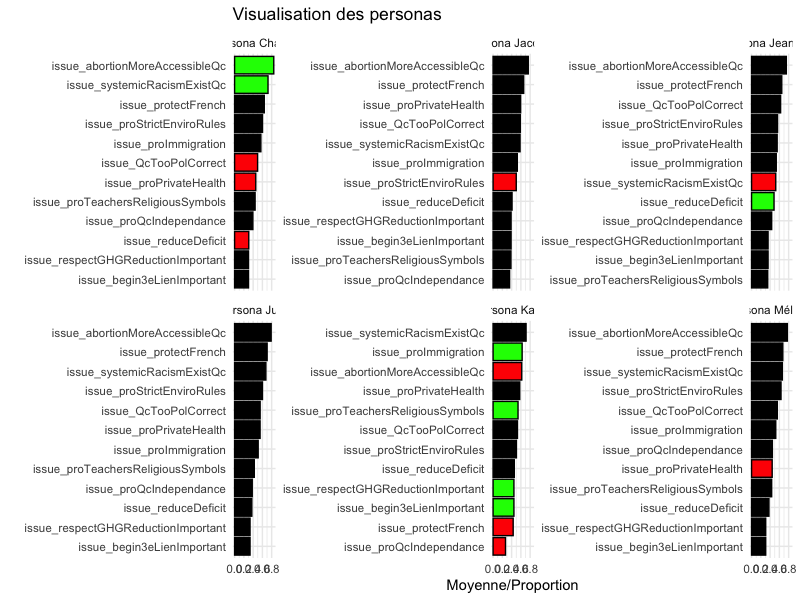

In [16]:
# Tri des données pour le graphique
all_data_viz <- all_data_viz %>%
  group_by(Persona) %>%
  arrange(desc(Mean)) %>%
  ungroup()

# Sauvegarder le graphique
ggplot(all_data_viz, aes(x = reorder_within(Variable, Mean, Persona), y = Mean, fill = Color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ Persona, scales = "free_y") +
  scale_x_reordered()

In [17]:
 # Génération du prompt de suggestion de noms
 cat(paste0("\nPour le persona ", cluster_value, " :\n",
 "\nLes caractéristiques suivantes définissent ce cluster par leur distinction marquée :\n\n",
 "Variables supérieures (le cluster se démarque par des valeurs élevées) :\n",
 if (any(characteristic_vars == "green")) {
   paste(variables_issues[characteristic_vars == "green"], collapse = "\n")
 } else {
   "Aucune variable supérieure ne se distingue fortement."
 },
 "\n\nVariables inférieures (le cluster se démarque par des valeurs faibles) :\n",
 if (any(characteristic_vars == "red")) {
   paste(variables_issues[characteristic_vars == "red"], collapse = "\n")
 } else {
   "Aucune variable inférieure ne se distingue fortement."
 },
 "\n\nCe cluster est composé de ", round(perc_femmes, 1), "% de femmes, ", 
 round(perc_immigrants, 1), "% d'immigrants, un âge moyen de ", round(age_mean, 1), 
 " ans et un revenu moyen de ", round(revenu_moyen, 1), " k$.\n",
 "\nSuggérez un nom qui reflète bien ces caractéristiques.\n",
 "Tu peux donner un prénom significatif suivi par un deux-points (:) et un nom descriptif.\n",
 "Finalement, décris la persona en 2-3 phrases, en tenant compte des scores d'importance et de la direction (élevée ou faible) de chaque variable pour ce cluster.\n\n"))


Pour le persona Mélanie :

Les caractéristiques suivantes définissent ce cluster par leur distinction marquée :

Variables supérieures (le cluster se démarque par des valeurs élevées) :
Aucune variable supérieure ne se distingue fortement.

Variables inférieures (le cluster se démarque par des valeurs faibles) :
issue_proPrivateHealth

Ce cluster est composé de 60.2% de femmes, 12.2% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.2 k$.

Suggérez un nom qui reflète bien ces caractéristiques.
Tu peux donner un prénom significatif suivi par un deux-points (:) et un nom descriptif.
Finalement, décris la persona en 2-3 phrases, en tenant compte des scores d'importance et de la direction (élevée ou faible) de chaque variable pour ce cluster.



Pour le persona Mélanie :

Les caractéristiques suivantes définissent ce cluster par leur distinction marquée :

Variables supérieures (le cluster se démarque par des valeurs élevées) :
Aucune variable supérieure ne se distingue fortem